To tackle the task of segmenting the fetal head in ultrasound images, we will be implementing a Convolutional Neural Network (CNN) using the PyTorch framework. This deep learning model will enable us to automatically identify and extract the fetal head from the ultrasound images. Our focus in this project is single-object segmentation, which involves automatically outlining the boundary of a specific target object within an image. This is achieved by creating a binary mask that defines the object boundary. By overlaying a contour on the image based on this binary mask, we can visually highlight the precise boundary of the target object. Then we will be employing is an encoder-decoder algorithm. By leveraging both an encoder and a decoder component, we can effectively capture the important features of the ultrasound images and accurately delineate the boundaries of the fetal head. We follow up by implementing a plain UNet model and compare the results obtained from both models.

To download the dataset, visit [website](https://zenodo.org/record/1322001#.ZBgHttJBy0l) and and go through the following steps:
* Download the training_set.zip and test_test.zip files.
* Extract them as training_set and test_set, respectively.

The training_set folder contains 1,998 ˙png files, including 999 images and 999 annotations. In addition, the test_set folder contains 335 ˙png images.
There are no annotation files in the test_set folder.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim
import cv2
from torchvision.transforms import CenterCrop


In [4]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read images from the drive

a=os.listdir('/content/drive/MyDrive/MLESA_CNN_Assignment/MLESA_CNN/test_set')
len(a)

335

In [6]:
n_train_cnt = 0
n_test_cnt = 0
train_file_name = []
test_file_name = []
max_width = 0
max_height = 0
min_width = 2000
min_height = 2000
base_path = '/content/drive/MyDrive/MLESA_CNN_Assignment/MLESA_CNN/'
# Iterate through each file in the training set directory
for path in os.listdir(base_path + "/training_set"):
    # Get the full file path
    f_path = os.path.join(base_path + "/training_set", path)
    i = 0
    if os.path.isfile(f_path):
        # Exclude files with '_Annotation' in their path
        if '_Annotation' not in f_path:
          n_train_cnt += 1
          # Store the file name (without the file extension)
          train_file_name.append(f_path[0:-4])
          # Read the image using OpenCV library
          img = cv2.imread(f_path, cv2.IMREAD_COLOR)
          # Convert the image to a NumPy array
          img = np.array([img])
          if img.shape[1] > max_width:
            max_width = img.shape[1]
          if img.shape[2] > max_height:
            max_height = img.shape[2]
          if img.shape[1] < min_width:
            min_width = img.shape[1]
          if img.shape[2] < min_height:
            min_height = img.shape[2]

for path in os.listdir(base_path + "/test_set" ):
    f_path = os.path.join(base_path + "/test_set", path)
    if os.path.isfile(f_path):
        n_test_cnt += 1
        test_file_name.append(f_path[0:-4])
        img = cv2.imread(f_path, cv2.IMREAD_COLOR)
        img = np.array([img])
        if img.shape[1] > max_width:
          max_width = img.shape[1]
        if img.shape[2] > max_height:
          max_height = img.shape[2]
        if img.shape[1] < min_width:
          min_width = img.shape[1]
        if img.shape[2] < min_height:
          min_height = img.shape[2]
print(f'We Have {n_train_cnt} Images and {n_train_cnt} Annotations in Train Set  and {n_test_cnt} Images in Test Set. ')
print(f"Min Image Width: {min_width} - Min Image Height: {min_height}")
print(f"Max Image Width: {max_width} - Max Image Height: {max_height}")

We Have 999 Images and 999 Annotations in Train Set  and 335 Images in Test Set. 
Min Image Width: 539 - Min Image Height: 738
Max Image Width: 563 - Max Image Height: 800


In [7]:
def seed_everything(seed=42):
	# Set the seed for NumPy random number generator
    np.random.seed(seed)
    # Set the seed for Python hash functions
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Set the CUDA environment variable for cuBLAS workspace configuration, this enables Colab to run GPU for given Model Configuration
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # Set the seed for Torch random number generator
    torch.manual_seed(seed)


In [8]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2) # Calculate centre of image
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0) # Create a rotation matrix using the center and angle
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR) # Apply the rotation transformation to image
  return result

In [9]:
def read_images(file_name, img_width, img_height, title = "", suffix = "", transform = False):
  i = 0
  print('-'*50)
  print(title, '- Reading Images...')
  print('-'*50)
  j = 0
  cntr = 0
  mul = 1
  if transform:
    mul = 7
  total = len(file_name)

  channel = 3
  if 'Annotation' in suffix:
    channel = 1
  X_train = torch.tensor(np.ndarray((mul * total, channel, img_width, img_height), dtype=np.uint8))


  for label in file_name: # Read Image
      img = cv2.imread(label + suffix, cv2.IMREAD_COLOR)
      img1 = cv2.cvtColor(img, cv2.IMREAD_COLOR)
      if channel == 1: # Read grayscale image
        image = cv2.imread(label + suffix, 0)
        im = image.copy()
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

        # Find contours and fit ellipse
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(im, ellipse, (255,255,255), -1)
        img1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

      # Resize Images
      scale_width =   img.shape[0] / img_width
      if img.shape[1] / img_height > scale_width:
        scale_width = img.shape[1] / img_height
      img1 = cv2.resize(img1, (int(img.shape[1] / scale_width), int(img.shape[0] / scale_width)))

      # Center Image
      top = int((img_height-img1.shape[1])/2)
      bottom = img_height-img1.shape[1] - top
      left = int((img_width-img1.shape[0])/2)
      right = img_width-img1.shape[0] - left
      img1 = cv2.copyMakeBorder(img1,left, right, top, bottom,  borderType=cv2.BORDER_CONSTANT, value=(0,0,0,0))

      # Transform Image
      if transform:
        base_img = []
        base_img.append(img1)
        base_img.append(rotate_image(img1, 30))
        base_img.append(rotate_image(img1, 60))
        if '_Annotation' not in suffix:
          base_img.append(cv2.blur(np.array(img1) ,(10,10)))
        else:
          base_img.append(img1)
        base_img.append(cv2.flip(np.array(img1) ,0))
        base_img.append(cv2.flip(np.array(img1) ,1))
        base_img.append(cv2.flip(np.array(img1) ,-1))
        for m in range(0, 7):
          img = base_img[m]
          # Convert to n,c,w,h
          image = torch.from_numpy(img)
          image = image[np.newaxis, :]
          if channel == 3:
            image = image.permute(0, 3, 1, 2)
          X_train[j + m] = image
        j += 4
      else:
        image = torch.from_numpy(img1)
        image = image[np.newaxis, :]
        if channel == 3:
          image = image.permute(0, 3, 1, 2)
        X_train[j] = image
        j += 1

      if cntr % 100 == 0:
          print('Read: {0}/{1} images'.format(cntr, total))
      cntr += 1

  print(title, ' - Reading Completed')
  return X_train


In [10]:
total_train = len(train_file_name)
total_test = len(test_file_name)
img_width = 224 # int(min_width / 4)
img_height = 224 # int(min_height / 4)

# Reading Train Images
X_train = read_images(train_file_name[0:700], img_width, img_height, title = "Train Images", suffix = ".png", transform = False)
X_validation = read_images(train_file_name[700:], img_width, img_height, title = "Validation Images", suffix = ".png", transform = False)
# Reading Train Annotations
Y_train = read_images(train_file_name[0:700], img_width, img_height, title = "Train Annotations", suffix = "_Annotation.png", transform = False)
Y_validation = read_images(train_file_name[700:], img_width, img_height, title = "Validation Annotations", suffix = "_Annotation.png", transform = False)
# Reading Test Images
X_test = read_images(test_file_name, img_width, img_height, title = "Test Images", suffix = ".png", transform = False)

print('Total Train Image Set Shape: ', X_train.shape)
print('Total Train Annotation Set Shape: ', Y_train.shape)
print('Total Validation Image Set Shape: ', X_validation.shape)
print('Total Validation Annotation Set Shape: ', Y_validation.shape)
print('Total Test Image Set Shape: ', X_test.shape)

--------------------------------------------------
Train Images - Reading Images...
--------------------------------------------------
Read: 0/700 images
Read: 100/700 images
Read: 200/700 images
Read: 300/700 images
Read: 400/700 images
Read: 500/700 images
Read: 600/700 images
Train Images  - Reading Completed
--------------------------------------------------
Validation Images - Reading Images...
--------------------------------------------------
Read: 0/299 images
Read: 100/299 images
Read: 200/299 images
Validation Images  - Reading Completed
--------------------------------------------------
Train Annotations - Reading Images...
--------------------------------------------------
Read: 0/700 images
Read: 100/700 images
Read: 200/700 images
Read: 300/700 images
Read: 400/700 images
Read: 500/700 images
Read: 600/700 images
Train Annotations  - Reading Completed
--------------------------------------------------
Validation Annotations - Reading Images...
----------------------------

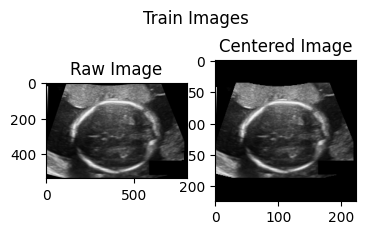

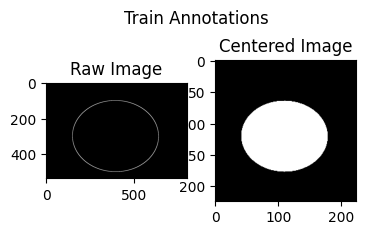

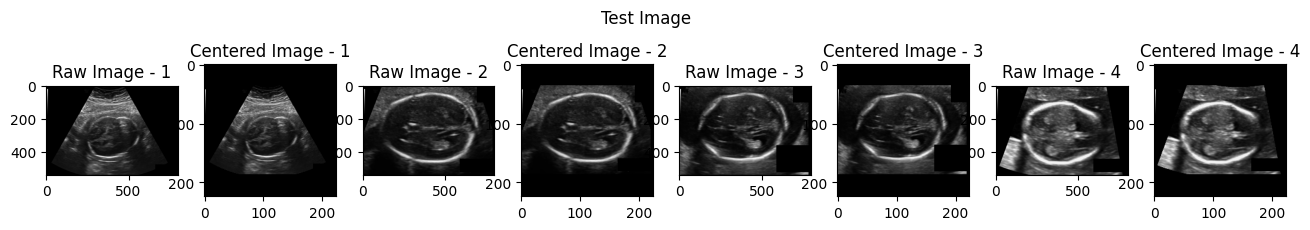

In [15]:
# plot the train images - along with the segmentation and initial test images

img = cv2.imread(train_file_name[0] + ".png", cv2.IMREAD_COLOR)
fig, axis = plt.subplots(1, 2, figsize=(4,2.5))
fig.suptitle('Train Images')
axis[0].imshow(img)
axis[0].set_title('Raw Image')
axis[1].imshow(X_train[0].permute(1, 2, 0))
axis[1].set_title('Centered Image')
"""
axis[2].imshow(X_train[1].permute(1, 2, 0))
axis[2].set_title('Rotated 30 Degree')
axis[3].imshow(X_train[2].permute(1, 2, 0))
axis[3].set_title('Rotated 60 Degree')
axis[4].imshow(X_train[3].permute(1, 2, 0))
axis[4].set_title('Slight Blurred')
axis[5].imshow(X_train[4].permute(1, 2, 0))
axis[5].set_title('Flipped around X')
axis[6].imshow(X_train[5].permute(1, 2, 0))
axis[6].set_title('Flipped around Y')
axis[7].imshow(X_train[6].permute(1, 2, 0))
axis[7].set_title('Flipped around Both')
"""

plt.show()

img = cv2.imread(train_file_name[0] + "_Annotation.png", cv2.IMREAD_COLOR)
fig, axis = plt.subplots(1, 2, figsize=(4,2.5))
fig.suptitle('Train Annotations')
axis[0].imshow(img)
axis[0].set_title('Raw Image')
axis[1].imshow(Y_train[0].permute(1, 2, 0), cmap='gray')
axis[1].set_title('Centered Image')
"""
axis[2].imshow(Y_train[1].permute(1, 2, 0), cmap='gray')
axis[2].set_title('Rotated 30 Degree')
axis[3].imshow(Y_train[2].permute(1, 2, 0), cmap='gray')
axis[3].set_title('Rotated 60 Degree')
axis[4].imshow(Y_train[3].permute(1, 2, 0), cmap='gray')
axis[4].set_title('Slight Blurred')
axis[5].imshow(Y_train[4].permute(1, 2, 0), cmap='gray')
axis[5].set_title('Flipped around X')
axis[6].imshow(Y_train[5].permute(1, 2, 0), cmap='gray')
axis[6].set_title('Flipped around Y')
axis[7].imshow(Y_train[6].permute(1, 2, 0), cmap='gray')
axis[7].set_title('Flipped around Both')
"""

plt.show()

fig, axis = plt.subplots(1, 8, figsize=(16,2.5))
fig.suptitle('Test Image')
for i in range (0, 4):
  img = cv2.imread(test_file_name[i] + ".png", cv2.IMREAD_COLOR)
  axis[2 * i].imshow(img)
  axis[2 * i].set_title(f'Raw Image - {i + 1}')
  axis[ 2 * i + 1].imshow(X_test[i].permute(1, 2, 0))
  axis[ 2 * i + 1].set_title(f'Centered Image - {i + 1}')

plt.show()

In [17]:
# Define the DataLoaders - train_loader, validation_loader, and test_loader
from torch.utils.data import TensorDataset, DataLoader

#Scaling/Normalization
train_dataset = TensorDataset(torch.Tensor(X_train/255),torch.Tensor(Y_train/255))
validation_dataset = TensorDataset(torch.Tensor(X_validation/255),torch.Tensor(Y_validation/255))
test_dataset= TensorDataset(torch.Tensor(X_test/255))

batch_size = 32 # Number of samples processed in each iteration

# The train_loader is shuffled during training to introduce randomness and prevent the model from overfitting.
# The validation_loader and test_loader are not shuffled as we want to evaluate the model's performance on ordered data.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

We are building a custom encoder - decoder model by mimicking SegNet Architecture - Though with lesser number of channels across the model since more channels causes Colab GPU to go over memory. Our Encoder will Convolve with Channels: 3, 16, 32, 64 and then Decoder will go back to 64, 32, 16, 1 - We use Sigmoid and BCE Loss to calculate the final Segmentation Mask:

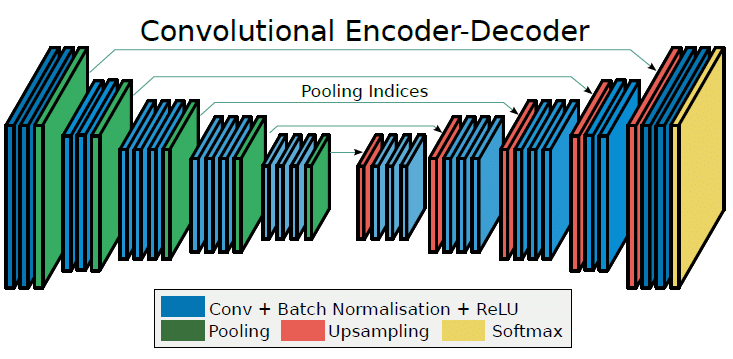

In [21]:
# Defining Encoder block
class ResEncoder(nn.Module):
  def __init__(self, channels=(3, 64, 128, 256, 512, 512), layers=(2,2,3,3,3)):
    super().__init__()
    self.encoderBlocks = nn.ModuleList(
    [ResEncoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x):
    resBlockOut = []
    resBlockIndices = []
    resSize = []
    i = 0
    for block in self.encoderBlocks:

      x, ind = block(x)
      resBlockOut.append(x)
      resBlockIndices.append(ind)
      size = x.size()
      resSize.append(size)
      #print(size, x.shape, ind.shape)
    return (resBlockOut, resBlockIndices, resSize)



In [22]:
# Defining Decoder block
class ResDecoder(nn.Module):
  def __init__(self, channels=(512, 512, 256, 128, 64, 32), layers=(3,3,3,2,2)):
    super().__init__()
    self.channels = channels
    self.decoderBlocks = nn.ModuleList(
      [ResDecoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x, encoderIndices, encoderSize ):
    i = 0
    for block in self.decoderBlocks:
      x = block(x, encoderIndices[i], encoderSize[i])
      i+= 1
    return x


In [24]:
# Creating Encoder Decoder model
class customEncoderDecoder(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512, 512),
               encoderLayer = (2,2,3,3,3) ,
               decoderChannels=(512, 512, 256, 128, 64, 32),
               decoderLayer = (3,3,3,2,2),
               outClassCount=1):
    super().__init__()
    self.encoder = ResEncoder(encoderChannels, encoderLayer)
    self.decoder = ResDecoder(decoderChannels, decoderLayer)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    (encoderOutput, encoderIndices, encoderSizes) = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderIndices[::-1], encoderSizes[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [25]:
from torch.autograd import Variable
from torch import Tensor
from sklearn import metrics
import seaborn as sns
import warnings

class Trainer:
    def __init__(self, net, criterion, optimizer, epoch, train_loader, test_loader, train_len, test_len):
        self.epoch = epoch
        self.model = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_len = train_len
        self.test_len = test_len
        self.training_loss = []
        self.test_loss = []
        self.test_dice = []
        self.training_dice = []

    def train_batch(self):

        iterations = (int(len(self.train_loader.dataset) / self.train_loader.batch_size)) + 1

        print(f'Running {iterations} Batches of Size {self.train_loader.batch_size} - Over {self.epoch} Epochs')

        for epoch in range(self.epoch):
          self.model.train()
          train_loss = 0
          test_loss = 0
          for (i, (x, y)) in enumerate(self.train_loader):
            (x, y) = (x.to(device), y.to(device))
            pred = self.model(x)
            loss = self.criterion(pred, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()


          with torch.no_grad():
            self.model.eval()
            for (x, y) in self.test_loader:
              (x, y) = (x.to(device), y.to(device))
              pred = self.model(x)
              loss = self.criterion(pred, y)
              test_loss += loss.item()

          avg_train_loss = train_loss / self.train_len
          avg_test_loss = test_loss / self.test_len

          self.training_loss.append(avg_train_loss)
          self.test_loss.append(avg_test_loss)

          _, train_dice_score = self.predict_mask_tensor(self.train_loader)
          _, test_dice_score = self.predict_mask_tensor(self.test_loader)
          self.training_dice.append(train_dice_score.item())
          self.test_dice.append(test_dice_score.item())

          print(f'Epoch: {(epoch + 1)}/{self.epoch} | ' +
                f'Training Loss: {avg_train_loss} ' +
                    f'| Test Loss: {avg_test_loss}')
        print("=" * 60)
        print(f'Training Dice Score: {self.training_dice[-1]}')
        print(f'Validation Dice Score: {self.test_dice[-1]}')
        print("=" * 60)

    def predict_mask_tensor(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            #prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.type(torch.FloatTensor)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask_test_data(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, x) in enumerate(train_loader):
            x = x[0].to(device)
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def get_dice_score(self, input, target):
        epsilon = 0.000001
        inp = input.to(device).flatten()
        tar = target.to(device).flatten()
        inter = torch.sum(inp * tar)
        union = torch.sum(inp) + torch.sum(tar) + epsilon

        t = (2 * inter.float() + epsilon) / union.float()
        #print(t, inp.max(), target.max())
        return t

    def get_dice_coeff(self, input, target):
        s = torch.FloatTensor(1).zero_().to(device)

        for i, c in enumerate(zip(input, target)):
          s = s + self.get_dice_score(c[0], c[1])

        return s / (i + 1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate= 1e-3
max_epoch = 10
seed_everything()
model = customEncoderDecoder(encoderChannels=(3, 16, 32, 64, 64),
               encoderLayer = (2,2,3,3) ,
               decoderChannels=(64,64, 32, 16),
               decoderLayer = (3,3,2,2)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
test_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                              max_epoch, train_loader,
                              validation_loader, train_len, test_len)
trainer.train_batch()


Running 22 Batches of Size 32 - Over 10 Epochs
Epoch: 1/10 | Training Loss: 0.01720181546040944 | Test Loss: 0.019740472868533438
Epoch: 2/10 | Training Loss: 0.01217916590826852 | Test Loss: 0.020875975439779735
Epoch: 3/10 | Training Loss: 0.009904102768216815 | Test Loss: 0.009434690343895087
Epoch: 4/10 | Training Loss: 0.008667408440794264 | Test Loss: 0.00864873093904859
Epoch: 5/10 | Training Loss: 0.007673935634749276 | Test Loss: 0.007520508706370325
Epoch: 6/10 | Training Loss: 0.006748560156141009 | Test Loss: 0.0066578732087061955
Epoch: 7/10 | Training Loss: 0.005980862677097321 | Test Loss: 0.006296013111254842
Epoch: 8/10 | Training Loss: 0.005279825351067952 | Test Loss: 0.00552406398747677
Epoch: 9/10 | Training Loss: 0.00470107010432652 | Test Loss: 0.005026422914453972
Epoch: 10/10 | Training Loss: 0.004205959215760231 | Test Loss: 0.004728301960887717
Training Dice Score: 0.7008876204490662
Validation Dice Score: 0.7008360028266907


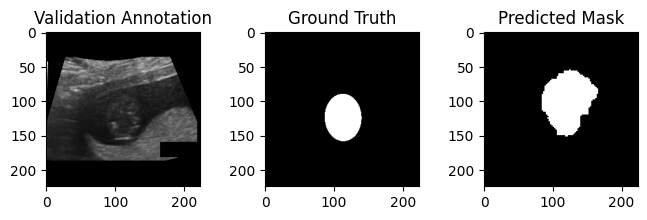

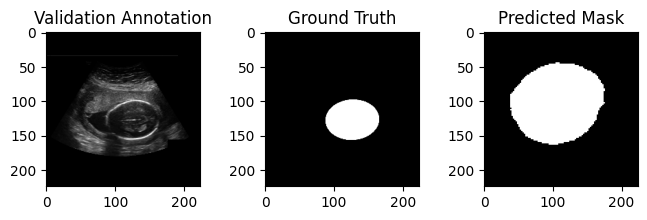

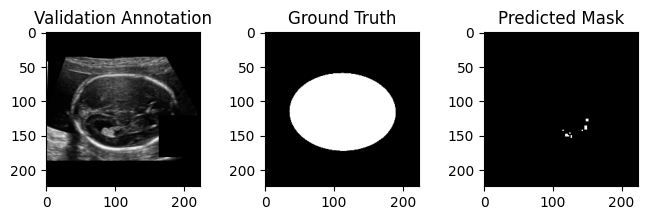

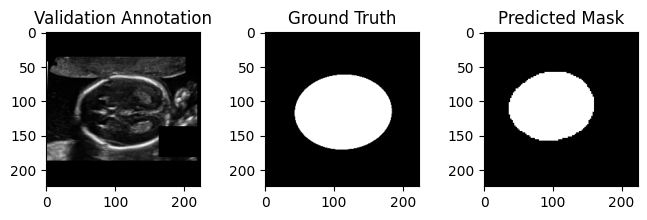

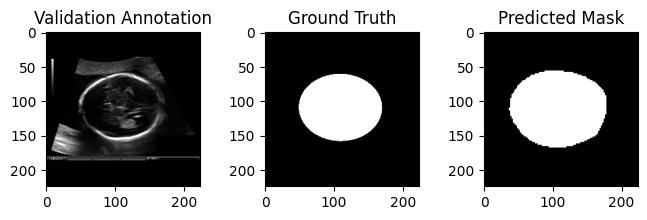

In [29]:
# Visualisaing the first 5 Images in Validation dataset - Image, Ground Truth and Predicted Mask
predicted_images_validation, dice = trainer.predict_mask(validation_loader)
for i in range (0, 5):

  fig, axis = plt.subplots(1, 3, figsize=(8,2))
  axis[0].imshow(X_validation[i].permute(1, 2, 0))
  axis[0].set_title('Validation Annotation')
  axis[1].imshow(Y_validation[i].permute(1, 2, 0), cmap='gray')
  axis[1].set_title('Ground Truth')
  axis[2].imshow(predicted_images_validation[i], cmap='gray')
  axis[2].set_title('Predicted Mask')

  plt.show()



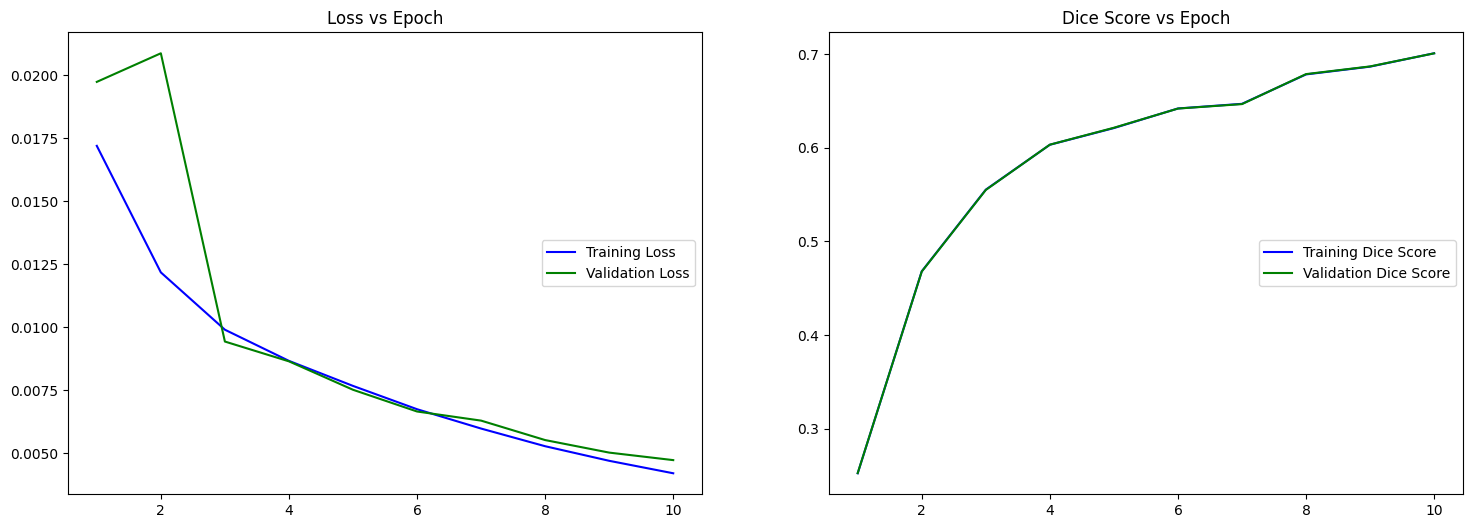

In [30]:
figure, axis = plt.subplots(1, 2, figsize=(18, 6))

#ax2 = axis[0].twinx()
x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label = 'Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.test_loss, label = 'Validation Loss', c = 'green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

#ax2 = axis[1].twinx()
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice , label = 'Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.test_dice, label = 'Validation Dice Score', c = 'green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')
plt.show()


Now we use a plain UNet model and compare the Dice score of the models. Here we define the building blocks for the UNet - Block, Encoder, Decoder and the Model.Again, we use only upto 512 channels due to GPU limit:

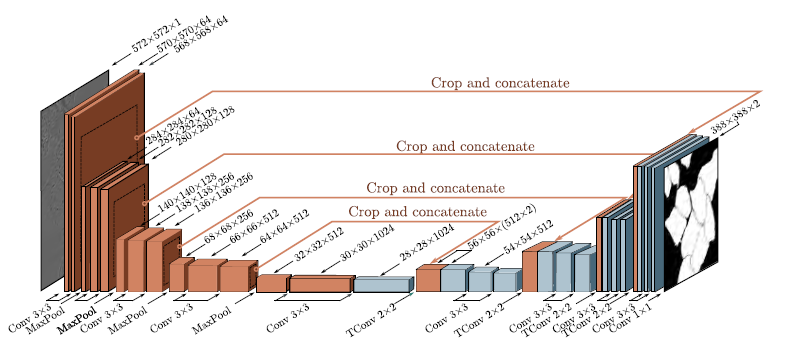

In [31]:
# Defining UNet Block
class UNetBlock(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)

  def forward(self, x):
    # CONV -> Batch Norm -> RELU -> CONV -> Batch Norm -> RELU
    return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))))

In [32]:
# Defining UNet Encoder
class UNetEncoder(nn.Module):
	def __init__(self, channels=(3, 64, 128, 256, 512, 1024)):
		super().__init__()
		self.encoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.max_pool = nn.MaxPool2d(2)
	def forward(self, x):
		resBlockOut = []
		for block in self.encoderBlocks:
			x = block(x)
			resBlockOut.append(x)
			x = self.max_pool(x)
		return resBlockOut



In [34]:
# Defining UNet Decoder
class UNetDecoder(nn.Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		self.channels = channels
		self.transposeConv = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.decoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])

	def forward(self, x, encoderOutputs):
		for i in range(len(self.channels) - 1):
			x = self.transposeConv[i](x)
			encFeat = self.crop(encoderOutputs[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.decoderBlocks[i](x)
		return x

	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures

In [35]:
class UNet(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512), decoderChannels=(512, 256, 128, 64), outClassCount=1):
    super().__init__()
    self.encoder = UNetEncoder(encoderChannels)
    self.decoder = UNetDecoder(decoderChannels)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    encoderOutput = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderOutput[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate= 1e-3
max_epoch = 10
seed_everything()
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
test_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                              max_epoch, train_loader,
                              validation_loader, train_len, test_len)
trainer.train_batch()


Running 22 Batches of Size 32 - Over 10 Epochs
Epoch: 1/10 | Training Loss: 0.01216708698443004 | Test Loss: 0.02108118665656916
Epoch: 2/10 | Training Loss: 0.00657832213810512 | Test Loss: 0.015028444420932527
Epoch: 3/10 | Training Loss: 0.004802928992680141 | Test Loss: 0.009118125889213588
Epoch: 4/10 | Training Loss: 0.0037980972017560687 | Test Loss: 0.005407666083562334
Epoch: 5/10 | Training Loss: 0.00324087065245424 | Test Loss: 0.00486207454399919
Epoch: 6/10 | Training Loss: 0.0027544910247836794 | Test Loss: 0.0033678172224740122
Epoch: 7/10 | Training Loss: 0.002306427024304867 | Test Loss: 0.002418043633866868
Epoch: 8/10 | Training Loss: 0.001953975638108594 | Test Loss: 0.0017353857066918375
Epoch: 9/10 | Training Loss: 0.0016973142272659711 | Test Loss: 0.001977160996617282
Epoch: 10/10 | Training Loss: 0.0016377813794783184 | Test Loss: 0.0016748496272093476
Training Dice Score: 0.9070592522621155
Validation Dice Score: 0.9071009755134583


## Observation:

We see huge increase in Dice Score for Train and Validation Dataset for UNet as compared to simple Encoder-Decoder algorithm since we are using Residual Network Architecture.

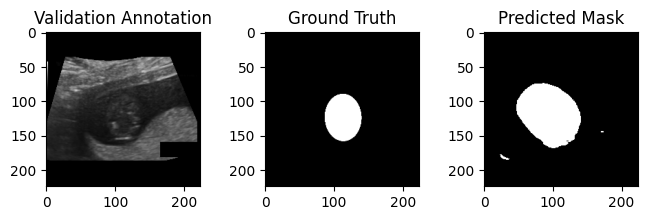

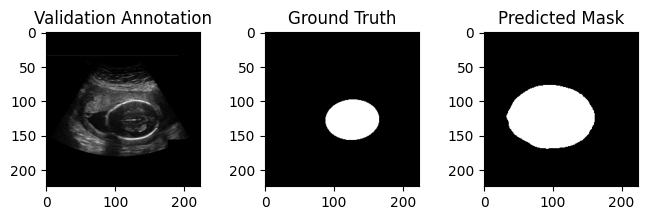

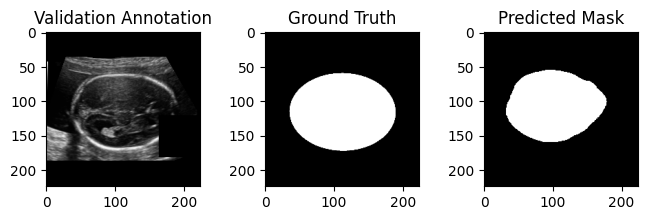

In [37]:
# Visualisaing the first 5 Images in Validation dataset - Image, Ground Truth and Predicted Mask
predicted_images_validation, dice = trainer.predict_mask(validation_loader)
for i in range (0, 3):

  fig, axis = plt.subplots(1, 3, figsize=(8,2))
  axis[0].imshow(X_validation[i].permute(1, 2, 0))
  axis[0].set_title('Validation Annotation')
  axis[1].imshow(Y_validation[i].permute(1, 2, 0), cmap='gray')
  axis[1].set_title('Ground Truth')
  axis[2].imshow(predicted_images_validation[i], cmap='gray')
  axis[2].set_title('Predicted Mask')

  plt.show()



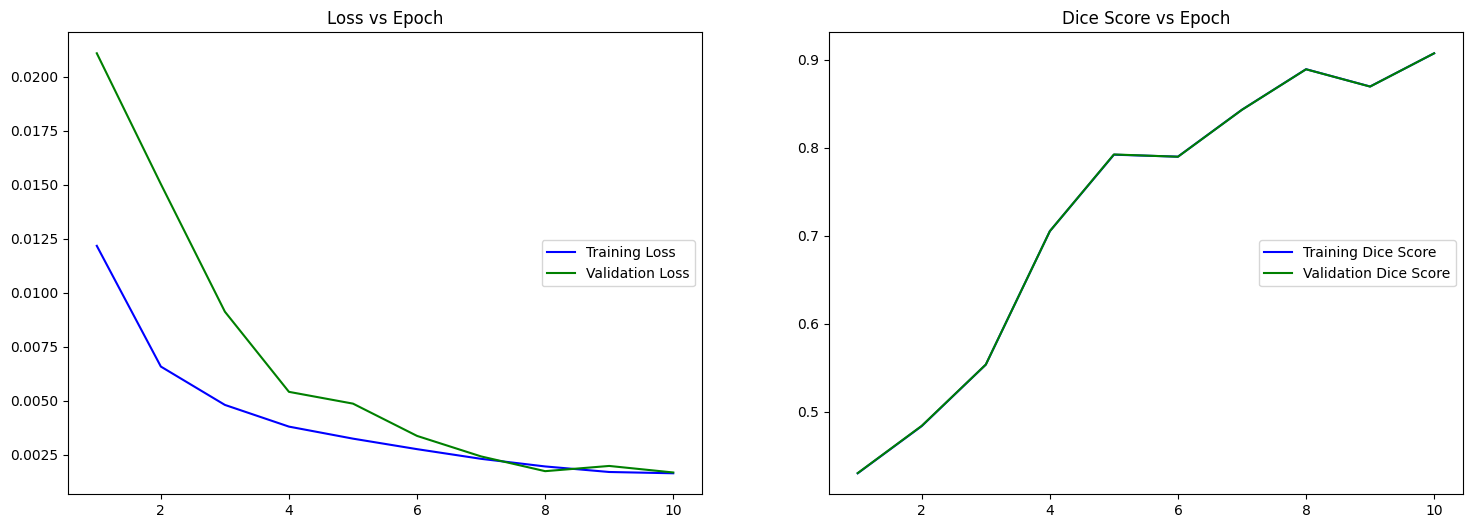

In [38]:
# Plotting the Losses and Dice Score vs Epoch:
figure, axis = plt.subplots(1, 2, figsize=(18, 6))

#ax2 = axis[0].twinx()
x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label = 'Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.test_loss, label = 'Validation Loss', c = 'green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

#ax2 = axis[1].twinx()
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice , label = 'Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.test_dice, label = 'Validation Dice Score', c = 'green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')
plt.show()


In [39]:
# Prediction for testing
predicted_images_test, dice = trainer.predict_mask_test_data(test_loader)


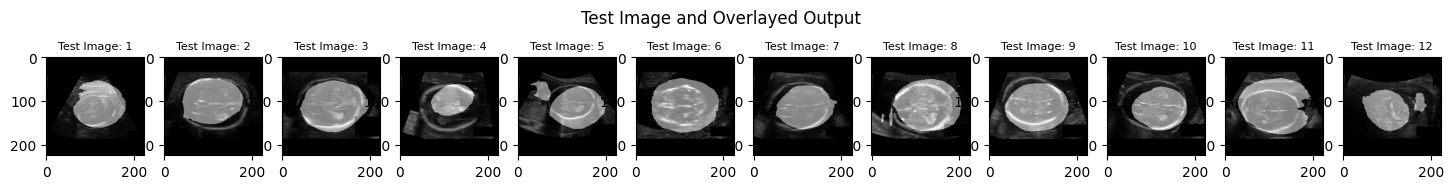

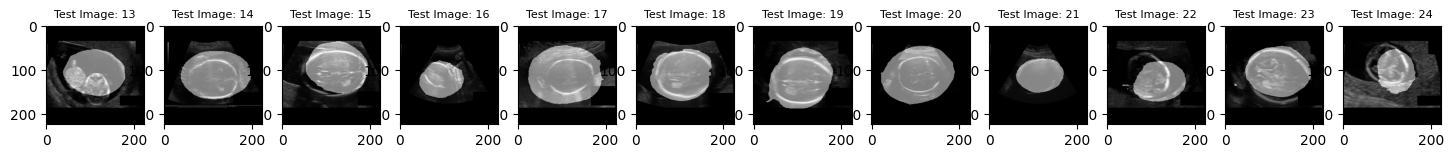

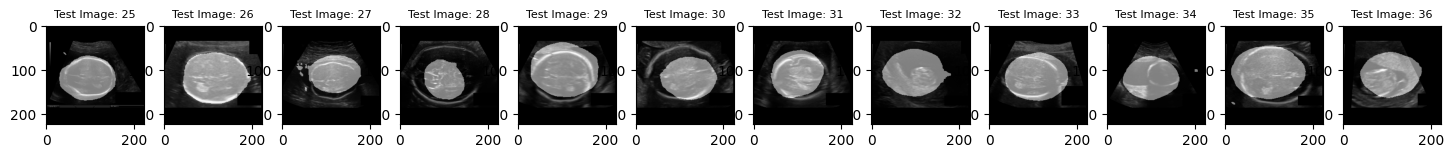

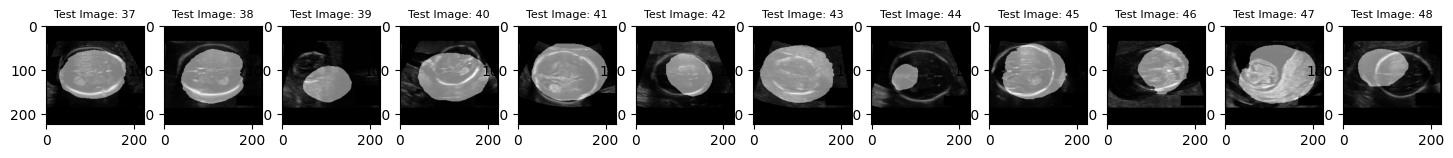

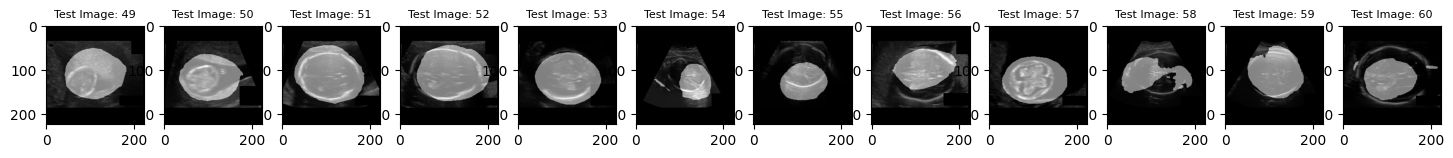

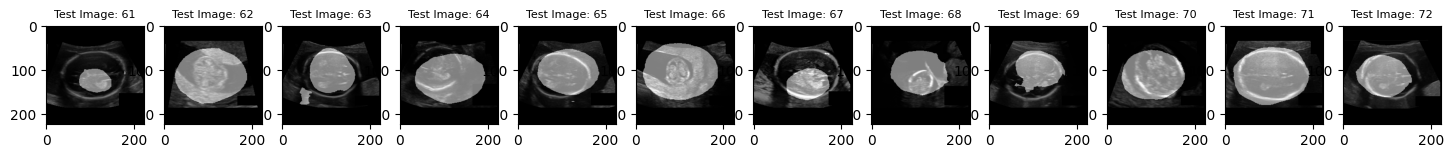

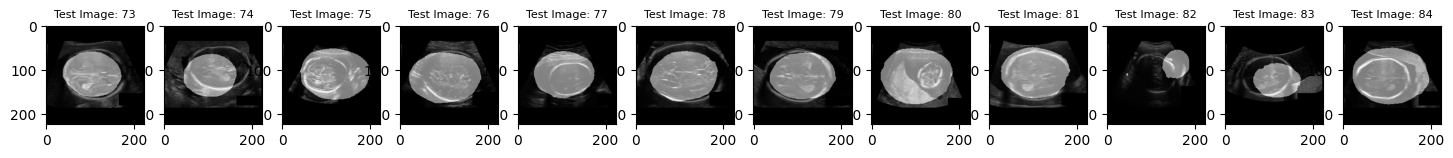

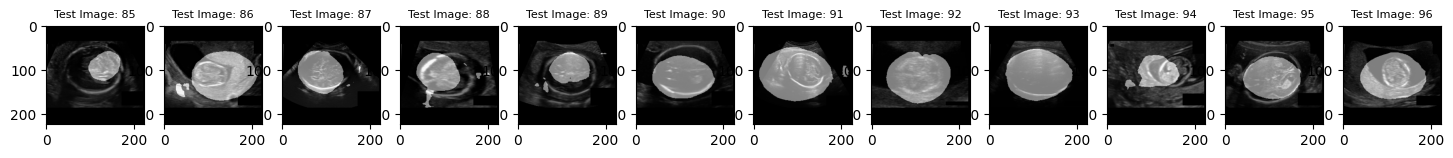

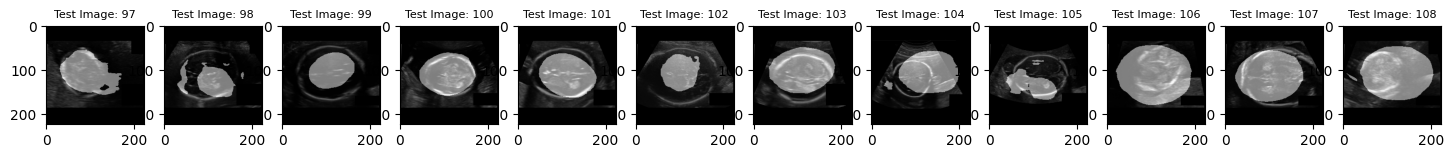

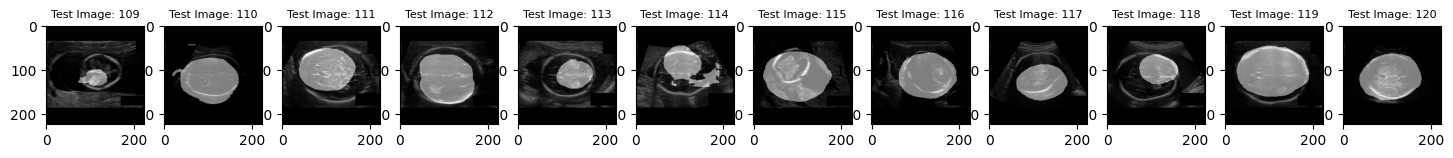

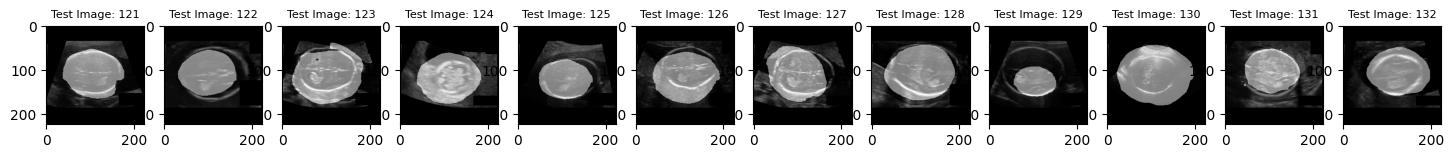

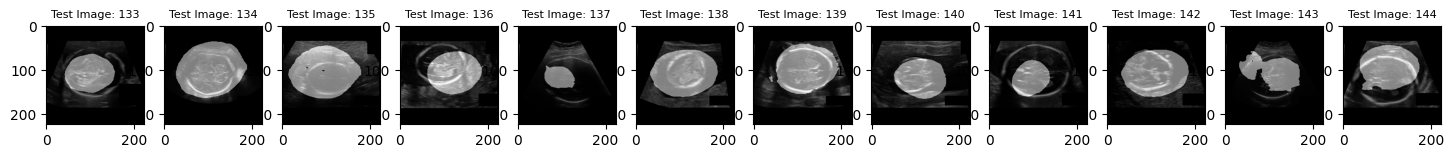

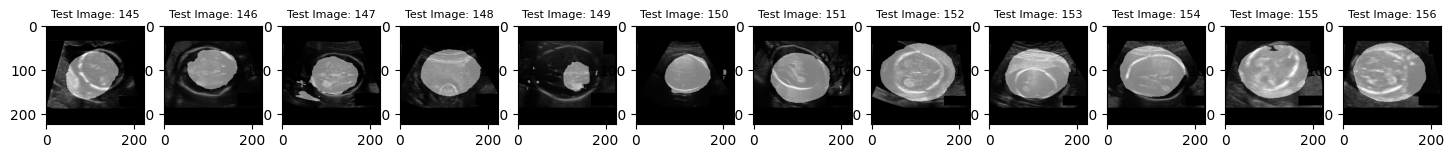

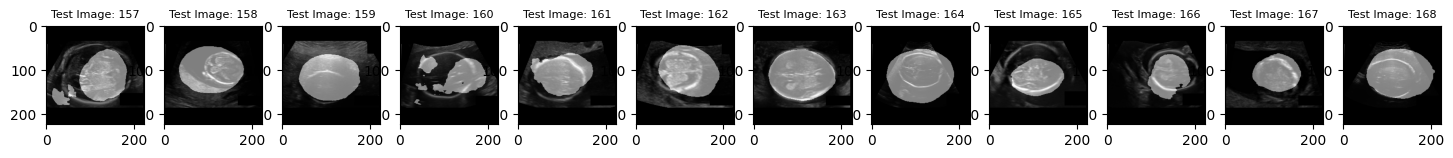

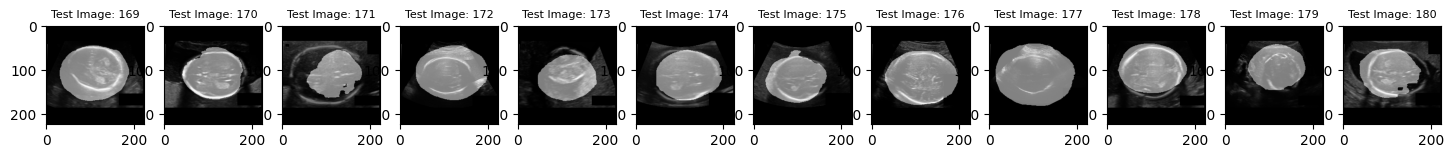

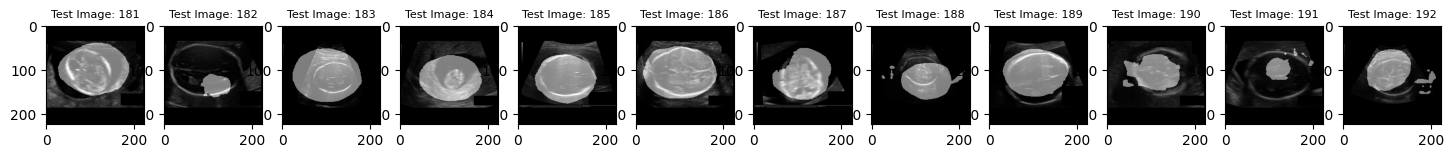

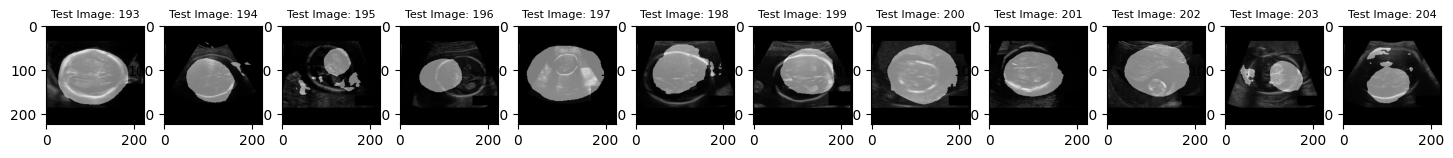

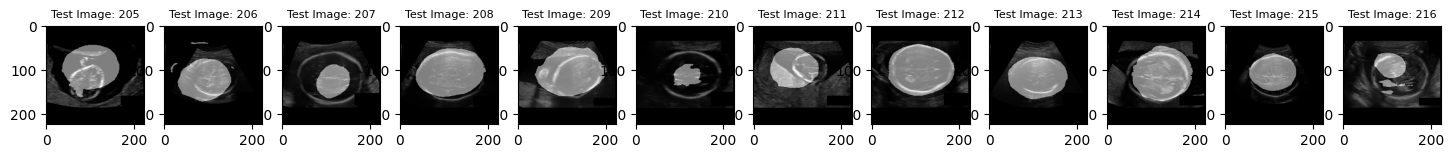

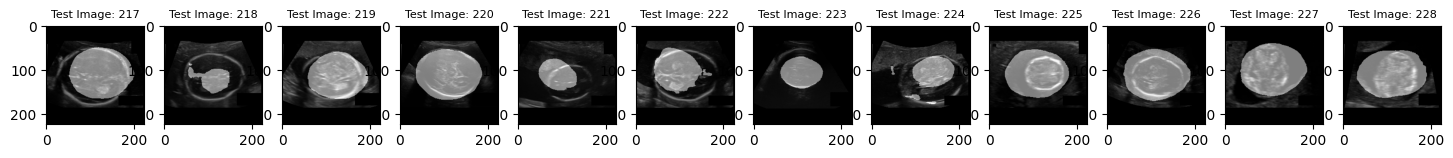

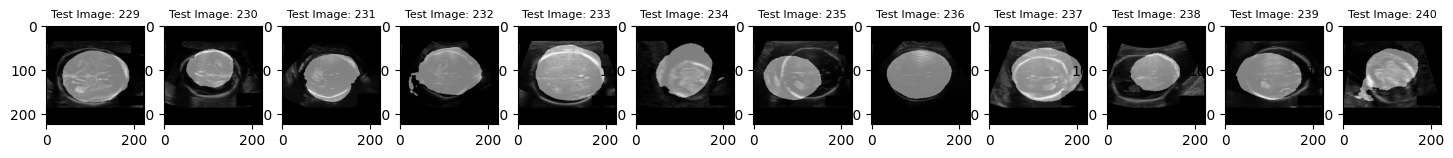

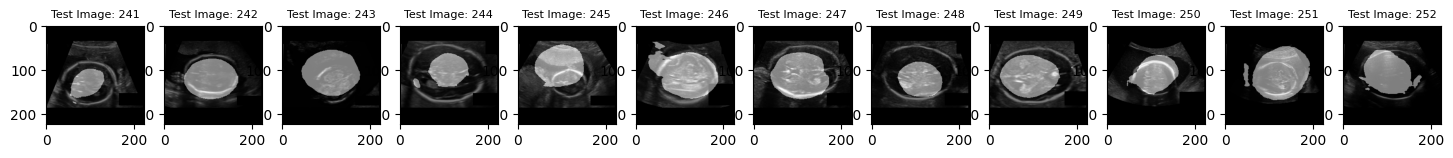

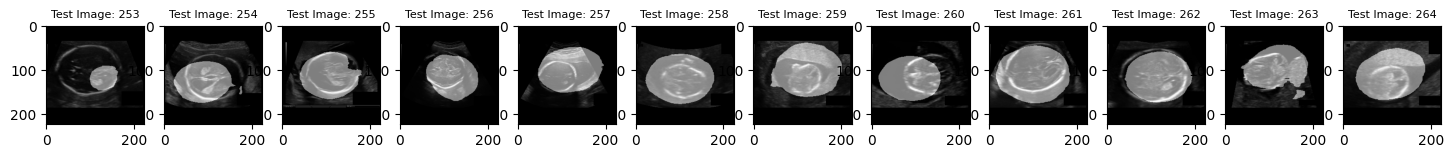

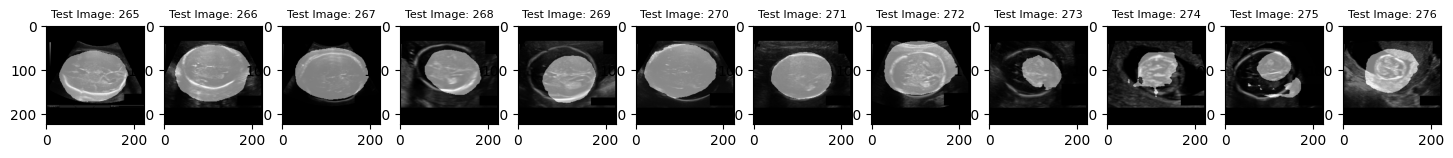

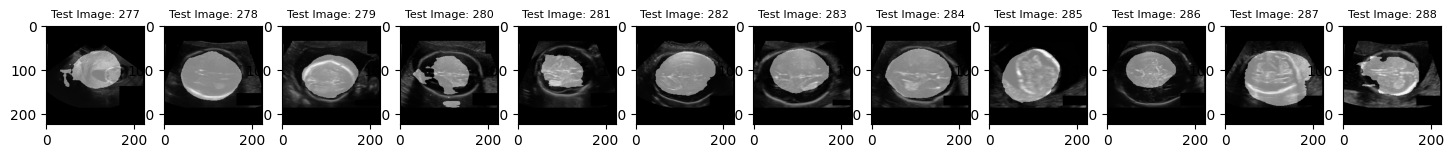

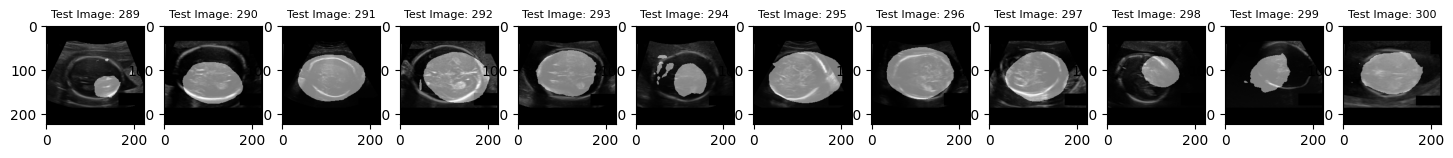

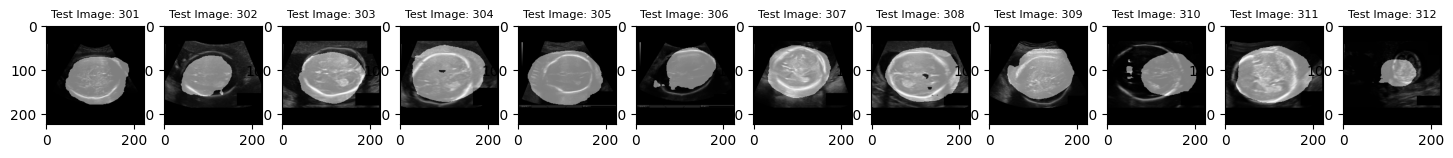

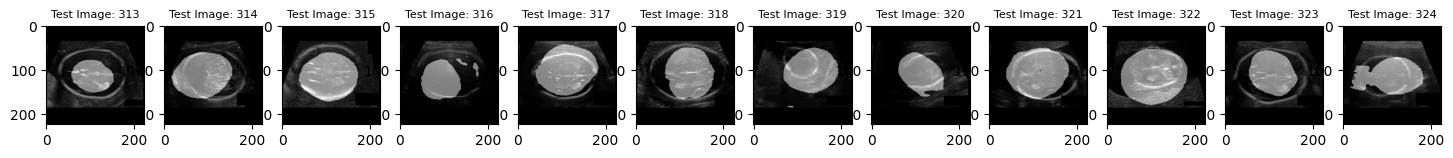

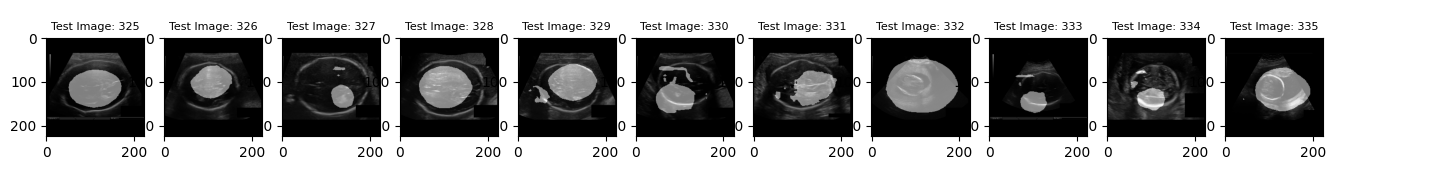

In [40]:
imagePerRow = 12
rows = int(len(X_test) / imagePerRow) + 1
for i in range (0, rows):
  fig, axis = plt.subplots(1, imagePerRow, figsize=(18,2))
  if i ==0:
    fig.suptitle('Test Image and Overlayed Output')
  m = 0
  for j in range(i * imagePerRow, (i + 1) * imagePerRow ):
    if j < len(X_test):
      axis[m].imshow(X_test[j].permute(1, 2, 0))
      axis[m].imshow(predicted_images_test[j], cmap='gray', alpha = 0.5)
      axis[m].set_title(f"Test Image: {j + 1}", fontsize=8)
    else:
      axis[m].axis('off')
    m += 1
  plt.show()

